In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import skbio
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib import rcParams as rcParams
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib import rc as rc
import matplotlib.gridspec as gridspec
from skbio.diversity import beta_diversity
from skbio.diversity import alpha_diversity
from skbio.stats.ordination import pcoa
from sklearn import decomposition
from sklearn.preprocessing import scale
import matplotlib.gridspec as gridspec
from skbio.stats.distance import mantel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
barcodes = pd.read_csv('../barcodes.csv', index_col=0)
barcodes

,Library,Site,Plot,Rep
sample_name,,,,
barcode01,Library1,ARDEC,85E,RepA
barcode02,Library1,ARDEC,85E,RepB
barcode03,Library1,ARDEC,85E,RepC
barcode04,Library1,ARDEC,86E,RepA
barcode05,Library2,ARDEC,85E,RepA
...,...,...,...,...
barcode83,Library3,ExtH2O,NaN,RepC
barcode84,Library3,Zymo,NaN,RepA
barcode85,Library1,PCR1H2O,NaN,RepA


In [3]:
file_path = '../illumina_Dan/'

In [4]:
mapping_file = barcodes.copy()

In [5]:
!ls $file_path

dada.cons.taxonomy  final.minimap.cons.taxonomy
dada.shared	    final.minimap.shared


In [7]:
minimap_taxa = pd.read_csv(file_path + 'final.minimap.cons.taxonomy', sep = '\t', index_col=0)
minimap_taxa.drop('OTU1', inplace=True)
print(minimap_taxa.shape)
minimap_taxa.head()

(57332, 2)


,Size,Taxonomy
OTU,,
OTU2,5.0,k__Archaea;p__Crenarchaeota;c__MBGA;o__NRP-J;f...
OTU3,2.0,k__Archaea;p__Crenarchaeota;c__MCG;o__pGrfC26;...
OTU4,1.0,k__Archaea;p__Crenarchaeota;c__MCG;o__pGrfC26;...
OTU5,4.0,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;...
OTU6,44.0,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;...


In [17]:
minimap_otu_table = pd.read_csv(file_path + 'final.minimap.shared', sep = '\t')
print(minimap_otu_table.shape)
minimap_otu_table = minimap_otu_table.drop(['label','numOtus'], axis = 1).set_index('group')
minimap_otu_table.drop('OTU1', axis = 1, inplace = True)
minimap_otu_table.head()

(105, 57336)


,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,OTU11,...,OTU57324,OTU57325,OTU57326,OTU57327,OTU57328,OTU57329,OTU57330,OTU57331,OTU57332,OTU57333
group,,,,,,,,,,,,,,,,,,,,,
ARD-T-Pow-85E-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARD-T-Pow-85E-2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARD-T-Pow-85E-3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARD-T-Pow-86E-1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARD-T-Pow-86E-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [18]:
mapping_file.head()

,Library,Site,Plot,Rep
sample_name,,,,
barcode01,Library1,ARDEC,85E,RepA
barcode02,Library1,ARDEC,85E,RepB
barcode03,Library1,ARDEC,85E,RepC
barcode04,Library1,ARDEC,86E,RepA
barcode05,Library2,ARDEC,85E,RepA


In [19]:
print(len(minimap_otu_table.columns))
print(len(minimap_taxa.index))
print(len(set(minimap_otu_table.columns) - set(minimap_taxa.index)))

57332
57332
0


In [20]:
# preparing phyla
minimap_otu_table.columns = [x.split('p__')[1].split(';')[0] if x != 'unclassified' else x for x in minimap_taxa['Taxonomy']]

In [21]:
barcodes

,Library,Site,Plot,Rep
sample_name,,,,
barcode01,Library1,ARDEC,85E,RepA
barcode02,Library1,ARDEC,85E,RepB
barcode03,Library1,ARDEC,85E,RepC
barcode04,Library1,ARDEC,86E,RepA
barcode05,Library2,ARDEC,85E,RepA
...,...,...,...,...
barcode83,Library3,ExtH2O,NaN,RepC
barcode84,Library3,Zymo,NaN,RepA
barcode85,Library1,PCR1H2O,NaN,RepA


In [24]:
minimap_otu_table_phyla = minimap_otu_table.copy()
minimap_otu_table_phyla['Site'] = [x[:3] for x in minimap_otu_table_phyla.index]
minimap_otu_table_phyla['Samples'] = minimap_otu_table_phyla.index
minimap_otu_table_phyla = minimap_otu_table_phyla.melt(id_vars=['Samples','Site'])
minimap_otu_table_phyla = minimap_otu_table_phyla.groupby(['Site','variable']).sum()
minimap_otu_table_phyla = minimap_otu_table_phyla.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
minimap_otu_table_phyla.rename(columns= {'variable':'Phyla','value':'Abundance'}, inplace = True)
# minimap_otu_table_phyla.drop(['Samples'], axis = 1, inplace = True)
minimap_otu_table_phyla

,Site,Phyla,Abundance
0,ARD,AC1,0.000048
1,ARD,AD3,0.000218
2,ARD,Acidobacteria,9.526404
3,ARD,Actinobacteria,40.562066
4,ARD,Aquificae,0.000242
...,...,...,...
350,Zym,WS4,0.000000
351,Zym,WS6,0.000000
352,Zym,WWE1,0.000000
353,Zym,ZB3,0.000000


In [25]:
minimap_otu_table_phyla.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [26]:
print(len(barcodes['Site'].values))
print(len(minimap_otu_table_phyla))
set(minimap_otu_table_phyla.index.values) - set(barcodes.index.values)

86
355


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [27]:
df_index = minimap_otu_table_phyla.groupby('Site', sort=False).sum().index
df_columns = minimap_otu_table_phyla[minimap_otu_table_phyla['Site'] == 'ARD']['Phyla']
minimap_otu_table_phyla_reshaped = pd.DataFrame(index = df_index, columns = df_columns)
minimap_otu_table_phyla_reshaped

Phyla,AC1,AD3,Acidobacteria,Actinobacteria,Aquificae,Armatimonadetes,BHI80-139,BRC1,Bacteroidetes,Caldiserica,...,Verrucomicrobia,WPS-2,WS1,WS2,WS3,WS4,WS6,WWE1,ZB3,unclassified
Site,,,,,,,,,,,,,,,,,,,,,
ARD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
print(len(minimap_otu_table_phyla_reshaped.loc['ARD',:]))
print(len(minimap_otu_table_phyla[minimap_otu_table_phyla['Site'] == 'ARD']['Abundance']))

71
71


In [29]:
print(len(minimap_otu_table_phyla[minimap_otu_table_phyla['Site'] == 'PCR']['Abundance']))

0


In [50]:
for i in df_index:
    print(i)
    for j in df_columns:
        if j in minimap_otu_table_phyla[minimap_otu_table_phyla['Site'] == i]['Phyla'].values:
#             print(minimap_otu_table_phyla[(minimap_otu_table_phyla['Site'] == i) & (minimap_otu_table_phyla['Phyla'] == j)]['Abundance'].values)
            minimap_otu_table_phyla_reshaped.loc[i,j] = minimap_otu_table_phyla[(minimap_otu_table_phyla['Site'] == i) & (minimap_otu_table_phyla['Phyla'] == j)]['Abundance'].values[0]
        else:
            minimap_otu_table_phyla_reshaped.loc[i,j] = 0
minimap_otu_table_phyla_reshaped.to_csv(file_path + 'minimap_otu_table_phyla_reshaped.csv')
minimap_otu_table_phyla_reshaped

ARD
Cal
H20
Pen
Zym


Phyla,AC1,AD3,Acidobacteria,Actinobacteria,Aquificae,Armatimonadetes,BHI80-139,BRC1,Bacteroidetes,Caldiserica,...,Verrucomicrobia,WPS-2,WS1,WS2,WS3,WS4,WS6,WWE1,ZB3,unclassified
Site,,,,,,,,,,,,,,,,,,,,,
ARD,4.83573e-05,0.000217608,9.5264,40.5621,0.000241786,0.0499289,0.00164415,0.0335358,1.64543,2.41786e-05,...,0.821686,0.00437633,0.00016925,0.00887356,0.263716,0.00016925,0.000459394,2.41786e-05,4.83573e-05,0.00901863
Cal,0,0.0703115,6.06769,64.5643,0,0.0424403,0,0.00506749,0.316085,0,...,1.6425,0.0475077,0,0.00443406,0.030405,0,0,0,0,0.0133022
H20,0,0.130561,3.33434,34.7695,0,0.0401727,0,0.271166,0.954103,0,...,1.44622,0.0100432,0,0,0.22095,0,0,0,0,0.0100432
Pen,6.60909e-05,0.0231759,9.64134,41.384,0.000198273,0.222087,0.0110592,0.0438844,2.00445,6.60909e-05,...,2.79271,0.162033,8.81212e-05,0.0222286,0.0124471,0.000198273,0.00140994,2.20303e-05,0.000132182,0.0277361
Zym,0,0,0.0134535,0.0717521,0,0.000896901,0,0,0.0026907,0,...,0.000896901,0,0,0,0,0,0,0,0,0


In [31]:
minimap_otu_table_phyla_reshaped_final = minimap_otu_table_phyla_reshaped.copy()
for i in df_columns:
    if minimap_otu_table_phyla_reshaped_final[i].sum() < 5:
#         print('yes', i)
        minimap_otu_table_phyla_reshaped_final = minimap_otu_table_phyla_reshaped_final.rename(columns = {i:'Other'})
minimap_otu_table_phyla_reshaped_final = minimap_otu_table_phyla_reshaped_final.groupby(minimap_otu_table_phyla_reshaped_final.columns, axis=1).sum()
# minimap_otu_table_phyla_reshaped_final = minimap_otu_table_phyla_reshaped_final.reindex(['ARDEC', 'Pendleton','ExtH2O','PCR1H2O','Zymo'])

In [32]:
minimap_otu_table_phyla_reshaped_final

Phyla,Acidobacteria,Actinobacteria,Chloroflexi,Cyanobacteria,Firmicutes,Gemmatimonadetes,Other,Planctomycetes,Proteobacteria,Verrucomicrobia
Site,,,,,,,,,,
ARD,9.526404,40.562066,11.714183,0.049421,1.026939,4.775497,2.928975,5.475057,23.119773,0.821686
Cal,6.067689,64.564291,6.243784,0.063344,1.740684,3.245729,1.394194,2.600257,12.437527,1.642501
H20,3.334338,34.769509,5.563925,18.841016,10.806468,2.269760,2.691574,3.314251,16.962941,1.446219
Pen,9.641340,41.384005,4.522842,0.110262,1.512953,3.766476,4.272953,6.586377,25.410077,2.792715
Zym,0.013454,0.071752,0.004485,0.000000,73.584466,0.003588,0.006278,0.001794,26.313288,0.000897


Text(0.5, 0, 'Site')

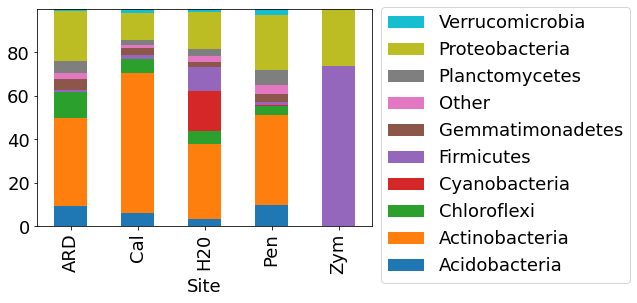

In [33]:
ax = minimap_otu_table_phyla_reshaped_final.plot(kind='bar', stacked=True, cmap='tab10', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.05), loc=2, fontsize = 18)
ax.set_xlabel('Site', fontsize = 18)

Text(0.5, 0, 'Site')

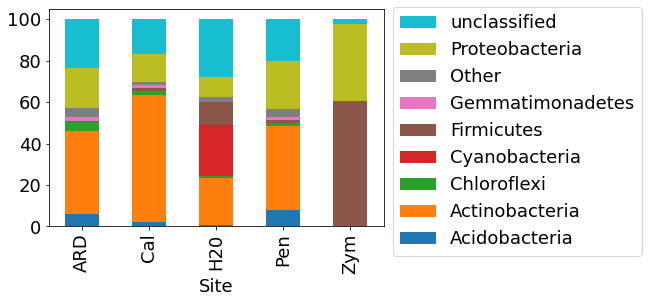

In [44]:
### Old version 

ax = minimap_otu_table_phyla_reshaped_final.plot(kind='bar', stacked=True, cmap='tab10', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.05), loc=2, fontsize = 18)
ax.set_xlabel('Site', fontsize = 18)

In [49]:
# Kingdom
minimap_otu_table_k = minimap_otu_table.copy()
minimap_otu_table_k.columns = [x.split('k__')[1].split(';')[0] if x != 'unclassified' else x for x in minimap_taxa['Taxonomy']]

minimap_otu_table_k['Site'] = [x[:3] for x in minimap_otu_table.index]
minimap_otu_table_k['Samples'] = minimap_otu_table_k.index
minimap_otu_table_k = minimap_otu_table_k.melt(id_vars=['Samples','Site'])
minimap_otu_table_k = minimap_otu_table_k.groupby(['Site','variable']).sum()
minimap_otu_table_k = minimap_otu_table_k.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
minimap_otu_table_k.rename(columns= {'variable':'Kingdom','value':'Abundance'}, inplace = True)
# # minimap_otu_table_phyla.drop(['Samples'], axis = 1, inplace = True)
minimap_otu_table_k

,Site,Kingdom,Abundance
0,ARD,Archaea,0.056312
1,ARD,Bacteria,99.943688
2,Cal,Archaea,0.030405
3,Cal,Bacteria,99.969595
4,H20,Archaea,0.030130
5,H20,Bacteria,99.969870
6,Pen,Archaea,0.015642
7,Pen,Bacteria,99.984358
8,Zym,Archaea,0.000000
9,Zym,Bacteria,100.000000
